# Cassava Plant Classification with Transfer Learning
This notebook demonstrates how to build a deep learning model to classify cassava plants into three categories:
1. Cassava Mosaic Disease
2. Healthy Cassava
3. Non-Cassava Plant

We'll use transfer learning with pre-trained models (ResNet50, EfficientNet, MobileNet) for better performance.


In [2]:
# Cassava Plant Classifier using Transfer Learning
# Classes: 1. Cassava Mosaic, 2. Healthy Cassava, 3. Non-Cassava Plant

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [15]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Configuration
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Class names
CLASS_NAMES = ['cassava_mosaic', 'healthy_cassava', 'non_cassava']
NUM_CLASSES = len(CLASS_NAMES)

# Data paths - Single folder structure
# Expected structure:
# data/
#   cassava_mosaic/
#   healthy_cassava/
#   non_cassava/

DATA_DIR = 'plants_folder'  # Main folder containing all class folders
TRAIN_DIR = 'data_split/train'
VALIDATION_DIR = 'data_split/validation'
TEST_DIR = 'data_split/test'

TensorFlow version: 2.18.0
GPU Available: []


In [6]:
# Automatic Dataset Splitting Function
def split_dataset(data_dir, output_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Split dataset from single folder structure into train/validation/test
    
    Args:
        data_dir: Path to main data directory containing class folders
        output_dir: Path where split data will be saved
        train_ratio: Proportion of data for training (default: 0.7)
        val_ratio: Proportion of data for validation (default: 0.2)
        test_ratio: Proportion of data for testing (default: 0.1)
    """
    import shutil
    from pathlib import Path
    import random
    
    # Ensure ratios sum to 1
    total_ratio = train_ratio + val_ratio + test_ratio
    if abs(total_ratio - 1.0) > 1e-6:
        raise ValueError(f"Ratios must sum to 1.0, got {total_ratio}")
    
    # Create output directories
    splits = ['train', 'validation', 'test']
    for split in splits:
        for class_name in CLASS_NAMES:
            Path(f"{output_dir}/{split}/{class_name}").mkdir(parents=True, exist_ok=True)
    
    # Process each class
    for class_name in CLASS_NAMES:
        class_dir = Path(data_dir) / class_name
        
        if not class_dir.exists():
            print(f"Warning: Class directory {class_dir} does not exist!")
            continue
        
        # Get all image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
        images = []
        for ext in image_extensions:
            images.extend(class_dir.glob(f"*{ext}"))
            images.extend(class_dir.glob(f"*{ext.upper()}"))
        
        if not images:
            print(f"Warning: No images found in {class_dir}")
            continue
        
        # Shuffle images
        random.shuffle(images)
        
        # Calculate split indices
        n_images = len(images)
        train_end = int(n_images * train_ratio)
        val_end = int(n_images * (train_ratio + val_ratio))
        
        # Split images
        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]
        
        # Copy images to respective directories
        for img_list, split in zip([train_images, val_images, test_images], splits):
            for img_path in img_list:
                dest_path = Path(f"{output_dir}/{split}/{class_name}/{img_path.name}")
                shutil.copy2(img_path, dest_path)
        
        print(f"Class {class_name}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")
    
    print(f"\nDataset split completed! Data saved to: {output_dir}")

In [ ]:
# Check if split data already exists, if not, create it
split_data_dir = 'data_split'
if not os.path.exists(split_data_dir):
    print("Splitting dataset...")
    split_dataset(DATA_DIR, split_data_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)
else:
    print("Split data already exists, using existing splits...")

In [9]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASS_NAMES,
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")


Found 9939 images belonging to 3 classes.
Found 3909 images belonging to 3 classes.
Found 2077 images belonging to 3 classes.
Training samples: 9939
Validation samples: 3909
Test samples: 2077
Class indices: {'cassava_mosaic': 0, 'healthy_cassava': 1, 'non_cassava': 2}


In [10]:
# Transfer Learning Model Architecture
def create_model():
    # Load pre-trained MobileNetV2 model
    base_model = MobileNetV2(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Add custom classification layers
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model, base_model

In [11]:
# Create the model
model, base_model = create_model()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

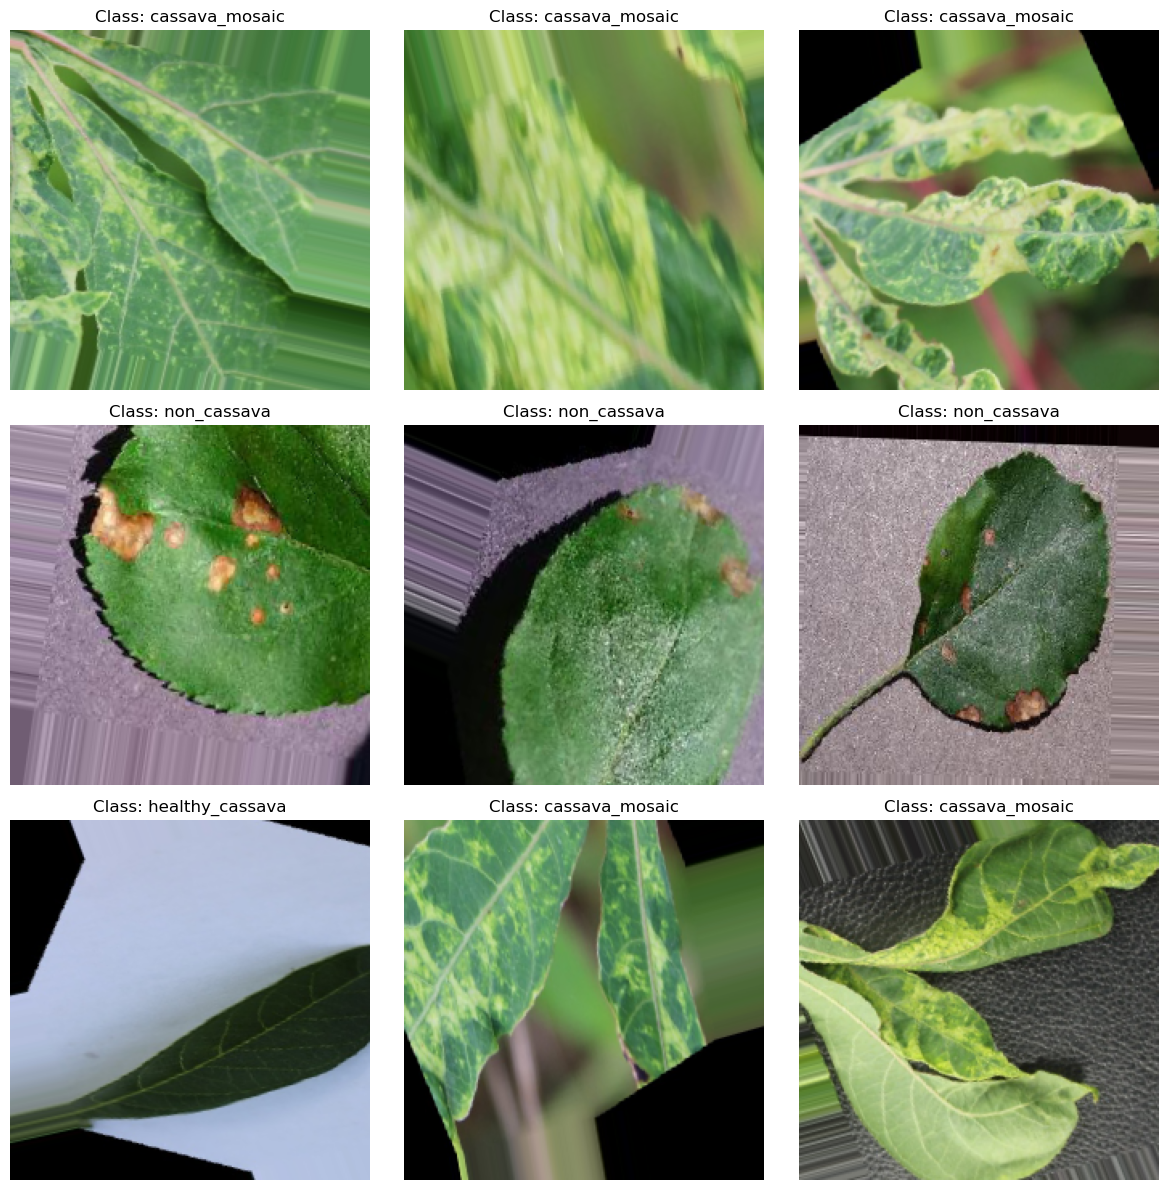

In [12]:

# Visualize sample images from training data
def plot_sample_images(generator, class_names, num_samples=9):
    plt.figure(figsize=(12, 12))
    
    # Get a batch of images
    images, labels = next(generator)
    
    for i in range(min(num_samples, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        # Get class name from one-hot encoded label
        class_idx = np.argmax(labels[i])
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
plot_sample_images(train_generator, CLASS_NAMES)

In [13]:
# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_cassava_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [16]:
# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9669 - loss: 0.1021
Epoch 1: val_accuracy improved from 0.97953 to 0.98030, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 241s 774ms/step - accuracy: 0.9669 - loss: 0.1021 - val_accuracy: 0.9803 - val_loss: 0.0606 - learning_rate: 1.0000e-04
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9702 - loss: 0.0897
Epoch 2: val_accuracy did not improve from 0.98030
311/311 ━━━━━━━━━━━━━━━━━━━━ 242s 777ms/step - accuracy: 0.9702 - loss: 0.0897 - val_accuracy: 0.9803 - val_loss: 0.0545 - learning_rate: 1.0000e-04
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9727 - loss: 0.0851
Epoch 3: val_accuracy improved from 0.98030 to 0.98312, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 306s 983ms/step - accuracy: 0.9727 - loss: 0.0851 - val_accuracy: 0.9831 - val_loss: 0.0479 - learning_rate: 1.0000e-04
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9727 - loss: 0.0807
Epoch 4: val_accuracy did not improve from 0.98312
311/311 ━━━━━━━━━━━━━━━━━━━━ 279s 898ms/step - accuracy: 0.9727 - loss: 0.0807 - val_accuracy: 0.9816 - val_loss: 0.0467 - learning_rate: 1.0000e-04
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.9751 - loss: 0.0745
Epoch 5: val_accuracy did not improve from 0.98312
311/311 ━━━━━━━━━━━━━━━━━━━━ 274s 882ms/step - accuracy: 0.9751 - loss: 0.0745 - val_accuracy: 0.9826 - val_loss: 0.0482 - learning_rate: 1.0000e-04
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.9794 - loss: 0.0658
Epoch 6: val_accuracy improved from 0.98312 to 0.98491, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 276s 886ms/step - accuracy: 0.9794 - loss: 0.0658 - val_accuracy: 0.9849 - val_loss: 0.0413 - learning_rate: 1.0000e-04
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9719 - loss: 0.0767
Epoch 7: val_accuracy improved from 0.98491 to 0.98542, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 274s 880ms/step - accuracy: 0.9719 - loss: 0.0767 - val_accuracy: 0.9854 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9794 - loss: 0.0591 
Epoch 8: val_accuracy improved from 0.98542 to 0.98874, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 6930s 22s/step - accuracy: 0.9794 - loss: 0.0591 - val_accuracy: 0.9887 - val_loss: 0.0369 - learning_rate: 1.0000e-04
Epoch 9/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.9750 - loss: 0.0692
Epoch 9: val_accuracy did not improve from 0.98874
311/311 ━━━━━━━━━━━━━━━━━━━━ 276s 888ms/step - accuracy: 0.9750 - loss: 0.0691 - val_accuracy: 0.9849 - val_loss: 0.0389 - learning_rate: 1.0000e-04
Epoch 10/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9794 - loss: 0.0569
Epoch 10: val_accuracy did not improve from 0.98874
311/311 ━━━━━━━━━━━━━━━━━━━━ 247s 794ms/step - accuracy: 0.9794 - loss: 0.0569 - val_accuracy: 0.9877 - val_loss: 0.0353 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


In [19]:
# Fine-tuning: Unfreeze some layers of the base model
def fine_tune_model(model, base_model, fine_tune_at=100):
    # Unfreeze the base model
    base_model.trainable = True
    
    # Freeze all layers except the last few
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # Recompile with a lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:
# Fine-tune the model
print("\nStarting fine-tuning...")
model = fine_tune_model(model, base_model)

# Continue training with fine-tuning
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Starting fine-tuning...
Epoch 10/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.9315 - loss: 0.1855
Epoch 10: val_accuracy did not improve from 0.98874
311/311 ━━━━━━━━━━━━━━━━━━━━ 296s 929ms/step - accuracy: 0.9316 - loss: 0.1853 - val_accuracy: 0.9747 - val_loss: 0.0715 - learning_rate: 1.0000e-05
Epoch 11/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.9727 - loss: 0.0743
Epoch 11: val_accuracy did not improve from 0.98874
311/311 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.9727 - loss: 0.0743 - val_accuracy: 0.9770 - val_loss: 0.0651 - learning_rate: 1.0000e-05
Epoch 12/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.9722 - loss: 0.0710
Epoch 12: val_accuracy did not improve from 0.98874
311/311 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9722 - loss: 0.0710 - val_accuracy: 0.9852 - val_loss: 0.0419 - learning_rate: 1.0000e-05
Epoch 13/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.9779 - loss: 0.0571
Epoch 13: val_accuracy

311/311 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.9829 - loss: 0.0419 - val_accuracy: 0.9890 - val_loss: 0.0310 - learning_rate: 1.0000e-05
Epoch 15/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9818 - loss: 0.0472
Epoch 15: val_accuracy did not improve from 0.98900
311/311 ━━━━━━━━━━━━━━━━━━━━ 283s 910ms/step - accuracy: 0.9818 - loss: 0.0472 - val_accuracy: 0.9870 - val_loss: 0.0346 - learning_rate: 1.0000e-05
Epoch 16/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.9866 - loss: 0.0361
Epoch 16: val_accuracy improved from 0.98900 to 0.99437, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9866 - loss: 0.0362 - val_accuracy: 0.9944 - val_loss: 0.0158 - learning_rate: 1.0000e-05
Epoch 17/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9843 - loss: 0.0375
Epoch 17: val_accuracy did not improve from 0.99437
311/311 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.9843 - loss: 0.0375 - val_accuracy: 0.9944 - val_loss: 0.0178 - learning_rate: 1.0000e-05
Epoch 18/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.9883 - loss: 0.0293
Epoch 18: val_accuracy improved from 0.99437 to 0.99565, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9883 - loss: 0.0293 - val_accuracy: 0.9957 - val_loss: 0.0140 - learning_rate: 1.0000e-05
Epoch 19/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9861 - loss: 0.0340
Epoch 19: val_accuracy improved from 0.99565 to 0.99667, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.9861 - loss: 0.0340 - val_accuracy: 0.9967 - val_loss: 0.0108 - learning_rate: 1.0000e-05
Epoch 20/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - accuracy: 0.9874 - loss: 0.0328
Epoch 20: val_accuracy improved from 0.99667 to 0.99693, saving model to best_cassava_model.h5


311/311 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.9874 - loss: 0.0328 - val_accuracy: 0.9969 - val_loss: 0.0102 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.


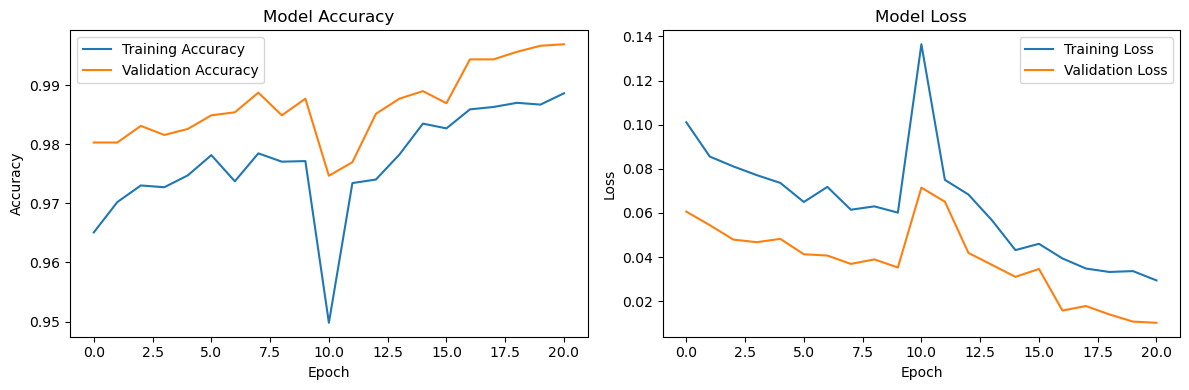

In [22]:
# Plotting training history
def plot_training_history(history, history_fine=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    if history_fine:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history, history_fine)

In [23]:
# Evaluate the model
print("\nEvaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")


Evaluating model on test set...
Test accuracy: 0.9937
Test loss: 0.0139


In [24]:

# Make predictions and generate classification report
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 397ms/step


In [25]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))


Classification Report:
                 precision    recall  f1-score   support

 cassava_mosaic       1.00      0.98      0.99       660
healthy_cassava       0.98      1.00      0.99       654
    non_cassava       1.00      1.00      1.00       763

       accuracy                           0.99      2077
      macro avg       0.99      0.99      0.99      2077
   weighted avg       0.99      0.99      0.99      2077



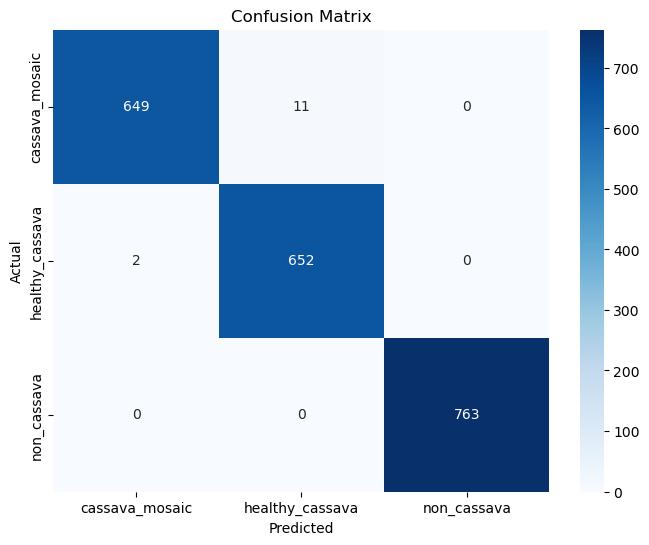

In [26]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
# Function to predict on a single image
def predict_image(image_path, model, class_names):
    """
    Predict the class of a single image
    """
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    img_array = img_array / 255.0  # Normalize
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence, predictions[0]

In [29]:
CLASS_NAMES

['cassava_mosaic', 'healthy_cassava', 'non_cassava']

In [1]:
IMG_SIZE

NameError: name 'IMG_SIZE' is not defined

In [30]:
model

<Sequential name=sequential, built=True>

In [34]:
# Example prediction (uncomment and provide image path)
image_path = 'test_plants/augmented_test_mosaic/0cassava_valid_mosaic.JPG'
predicted_class, confidence, probabilities = predict_image(image_path, model, CLASS_NAMES)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")
print(f"Probabilities: {dict(zip(CLASS_NAMES, probabilities))}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted class: cassava_mosaic
Confidence: 0.9983
Probabilities: {'cassava_mosaic': 0.99831164, 'healthy_cassava': 0.000481068, 'non_cassava': 0.0012073017}


In [35]:
# Save the final model
model.save('cassava_classifier_final.h5')
print("\nModel saved as 'cassava_classifier_final.h5'")

# Model summary
print("\nFinal Model Architecture:")
model.summary()


Model saved as 'cassava_classifier_final.h5'

Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,473,931 (24.70 MB)

 Trainable params: 2,025,795 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,051,592 (15.46 MB)

In [36]:
# Feature extraction function
def extract_features(image_path, model):
    """
    Extract features from the second-to-last layer
    """
    # Create a new model that outputs features from the dense layer
    feature_extractor = keras.Model(
        inputs=model.input,
        outputs=model.layers[-2].output  # Second-to-last layer
    )
    
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0
    
    features = feature_extractor.predict(img_array)
    return features

print("\nTraining completed successfully!")
print(f"Final test accuracy: {test_accuracy:.4f}")


Training completed successfully!
Final test accuracy: 0.9937


In [3]:
def model_prediction(image_path):
    """
    Predict the class of a single image
    """
    class_names = ['cassava_mosaic', 'healthy_cassava', 'non_cassava']
    model = tf.keras.models.load_model('cassava_classifier_final.h5')
    IMG_SIZE = (224, 224)
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    img_array = img_array / 255.0  # Normalize
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence, predictions[0]

In [5]:
model_prediction('test_plants/augmented_test_mosaic/0cassava_valid_mosaic.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


('cassava_mosaic',
 0.99831164,
 array([9.9831164e-01, 4.8106801e-04, 1.2073017e-03], dtype=float32))